# Model Evaluation with PyTorch and Scikit-Learn

In [1]:
import torch
from torch import nn
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.models.densenet import DenseNet161_Weights
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import time
import os
import cv2
import dask
import dask.array as da
from dask.distributed import Client, LocalCluster

# Warnings off
import warnings
warnings.filterwarnings("ignore")

### Load Test Dataset and Apply Transformation 

In [2]:
test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
])

batch_size = 64

test_data = datasets.ImageFolder('/scratch/gohil.de/Pediatric Chest X-ray Pneumonia/test', transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Transfer Learning

The model uses a pre-trained DenseNet-161 model as its base.

Added custom linear layer classifier  to the model, replacing the original classifier of the DenseNet-161.

In [3]:
class DenseNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNetModel, self).__init__()
        # Load a pre-trained DenseNet-161
        self.base_model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
        # Freeze the weights of the pre-trained model
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Build a custom classifier
        # Note: `classifier` is a linear layer in DenseNet-161
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)
model = DenseNetModel()

In [4]:
PATH = "model_20_epoch.pth"
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()

DenseNetModel(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, mo

In [5]:
def get_probs_and_preds(model, loader, device= 'cpu'):
    model.eval()
    
    images_savings = []
    labels_savings = []
    probs_savings  = []
    preds_savings  = []
    
    # Batch Loop
    for images, labels in iter(loader):                                             
        images, labels = images.to(device), labels.to(device) 
        
    # Evaluation
        with torch.set_grad_enabled(False):        
            output = model(images)
            output = F.softmax(output, dim=-1)
            probabilities, predictions = torch.max(output, dim=1) 
        
        images_savings.append(images.cpu()) 
        labels_savings += labels.tolist()                                           
        probs_savings  += probabilities.tolist()                                    
        preds_savings  += predictions.tolist()   
        
    # Accuracy
    correct_elements = 0
    for i in range(len(labels_savings)):
        if labels_savings[i] == preds_savings[i]:
            correct_elements += 1
    accuracy = correct_elements/len(labels_savings)

    return images_savings, labels_savings, probs_savings, preds_savings, accuracy

### Load images to Dask Array and used map_blocks for model Validation on different worker size

In [6]:
# Function to load and preprocess an image
def preprocess_image(image_path):
    # Load image using OpenCV
    image = cv2.imread(image_path)
    # Resize image to match input size of the model (e.g., 224x224)
    image = cv2.resize(image, (256, 256))
    # Convert image to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normalize image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)
    return image

# Function to convert images in a folder to NumPy arrays
def folder_to_dask(folder_path):
    images = []
    labels = []
    # Iterate over subfolders in the main folder
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        # Skip non-directory files
        if not os.path.isdir(class_folder):
            continue
        # Iterate over image files in the class folder
        for filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, filename)
            # Preprocess image and append to list
            image = preprocess_image(image_path)
            images.append(image)
            # Append label (0 for NORMAL, 1 for PNEUMONIA)
            label = 0 if class_name == 'NORMAL' else 1
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to predict using PyTorch model
def predict(images_chunk):
    # Convert Dask array chunk to PyTorch tensor
    images_chunk = torch.tensor(images_chunk)
    with torch.no_grad():
        outputs = model(images_chunk)
        output = F.softmax(outputs, dim=-1)
        _, predictions = torch.max(output, dim=1)
    # Ensure predictions have the same shape across all blocks
    return predictions.numpy()  # Add an extra dimension to make it consistent


### Load images from file path and convert into Dask Array

In [7]:
# Load and preprocess images using Dask
folder_path = '/scratch/gohil.de/Pediatric Chest X-ray Pneumonia/test'
images, labels = folder_to_dask(folder_path)
images_dask = da.from_array(images, chunks=(624, 3, 256, 256))

In [8]:
client = Client(n_workers = 4, threads_per_worker = 2)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43774/status,
Dashboard: http://127.0.0.1:43774/status,Workers: 4
Total threads: 8,Total memory: 50.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35860,Workers: 4
Dashboard: http://127.0.0.1:43774/status,Total threads: 8
Started: Just now,Total memory: 50.00 GiB
Comm: tcp://127.0.0.1:43337,Total threads: 2
Dashboard: http://127.0.0.1:43872/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:42391,


In [10]:
# Run prediction on the test data with different numbers of workers
execution_times = []
results = []
for n_workers in [1, 2, 4, 8, 16]:
    with dask.config.set(scheduler='threads', num_workers=n_workers):
        predictions_dask = images_dask.map_blocks(predict, dtype=np.int64, chunks=(images.shape[0] // n_workers, images.shape[1], images.shape[2], images.shape[3]))
        start_time = time.time()
        predictions = predictions_dask.compute()
        elapsed_time = time.time() - start_time
        execution_times.append((n_workers, elapsed_time))
        results.append((n_workers, predictions))
        print(f"Number of workers: {n_workers}, Elapsed time: {elapsed_time} seconds")

# Shutdown Dask client and cluster
client.close()

Number of workers: 1, Elapsed time: 136.37788844108582 seconds
Number of workers: 2, Elapsed time: 76.81122851371765 seconds
Number of workers: 4, Elapsed time: 79.26524233818054 seconds
Number of workers: 8, Elapsed time: 81.57763171195984 seconds
Number of workers: 16, Elapsed time: 81.08093690872192 seconds


### Dask: Number of workers Vs Time Taken Grpah

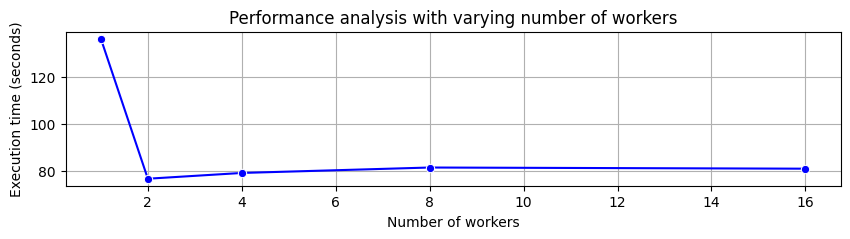

In [11]:
plt.figure(figsize=(10, 2))

sns.lineplot(x=[worker for worker, _ in execution_times], y=[t[1] for t in execution_times], marker='o', color='blue')
plt.xlabel('Number of workers')
plt.ylabel('Execution time (seconds)')
plt.title('Performance analysis with varying number of workers')
plt.grid(True)
plt.show()

### Dask: Number of CPUs Vs Speed Up Grpah

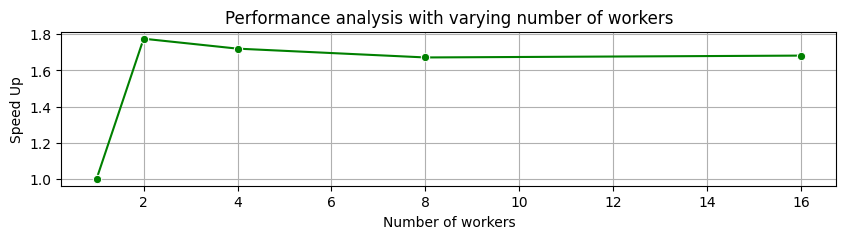

In [12]:
plt.figure(figsize=(10, 2))
speedup = [execution_times[0][1] / t[1] for t in execution_times]
sns.lineplot(x=[worker for worker, _ in execution_times], y=speedup, marker='o', color="green")
plt.xlabel('Number of workers')
plt.ylabel('Speed Up')
plt.title('Performance analysis with varying number of workers')
plt.grid(True)
plt.show()

### Dask: Number of CPUs Vs Efficiency Grpah

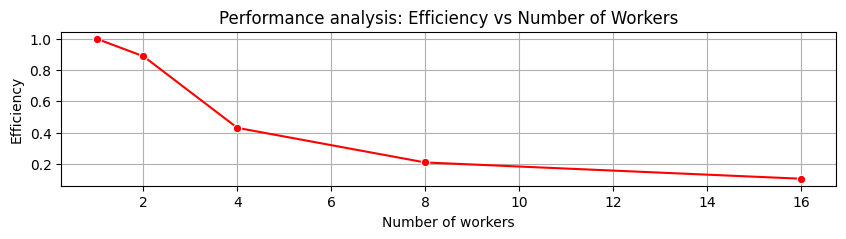

In [13]:
plt.figure(figsize=(10, 2))

sns.lineplot(x=[worker for worker, _ in execution_times], y=[speedup[i]/execution_times[i][0] for i in range(len(speedup))], marker='o', color="red")
plt.xlabel('Number of workers')
plt.ylabel('Efficiency')
plt.title('Performance analysis: Efficiency vs Number of Workers')
plt.grid(True)
plt.show()

In [14]:
# Evaluate the model on test data
images, labels, probs, preds, accuracy = get_probs_and_preds(model, test_loader)

# Print results
print(f'Accuracy on test: {accuracy * 100:.2f}')

Accuracy on test: 66.35


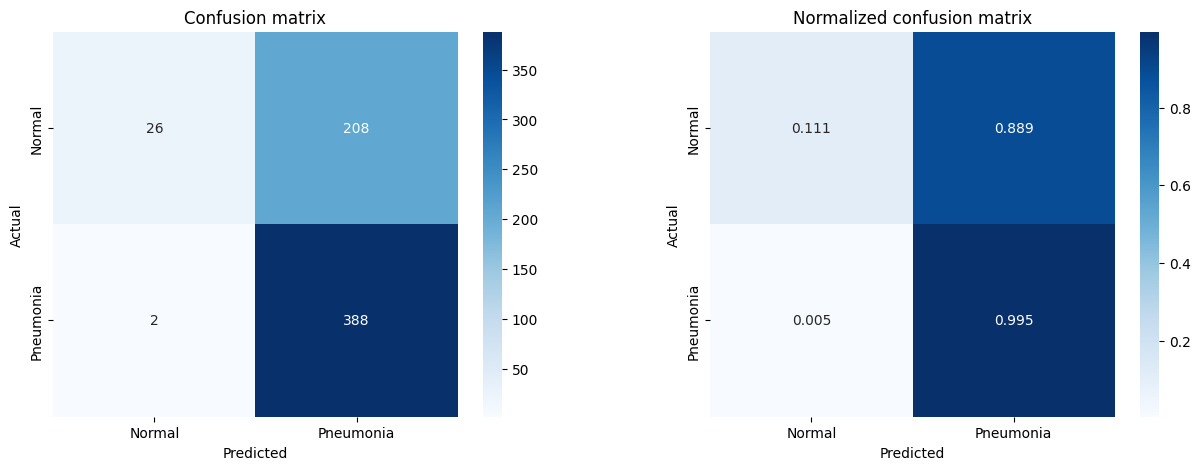

In [15]:
# Build the confusion matrix
cm = confusion_matrix(labels, preds)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Ticklables
ticklabels = ['Normal', 'Pneumonia']

# Plot
fig, ax = plt.subplots(figsize=(15,5))

# Confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Normalized confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

plt.subplots_adjust(wspace=.3)

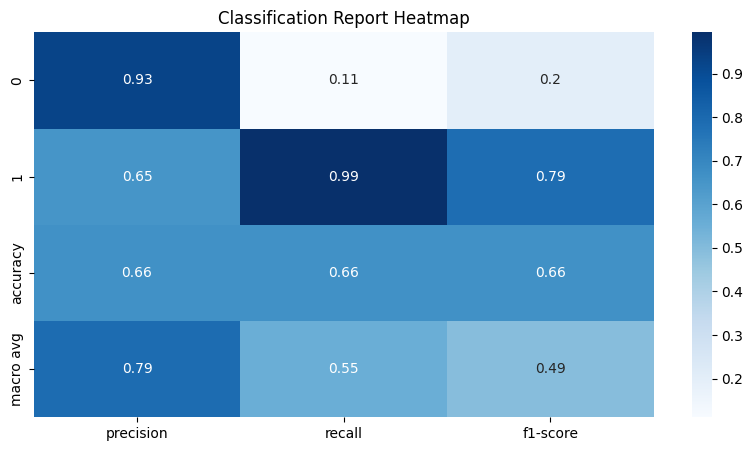

In [16]:
probs_array = np.array(probs)

# Classification report heatmap
report = classification_report(labels, preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :].drop(columns='support'), annot=True, cmap="Blues")
plt.title("Classification Report Heatmap")
plt.show()

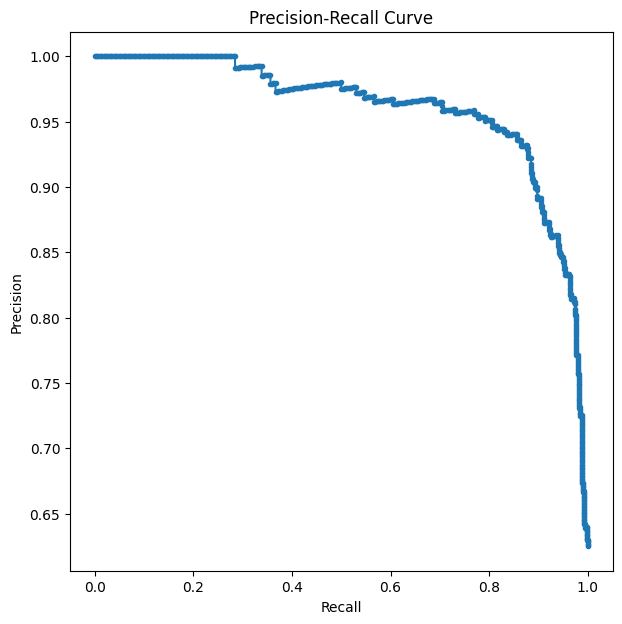

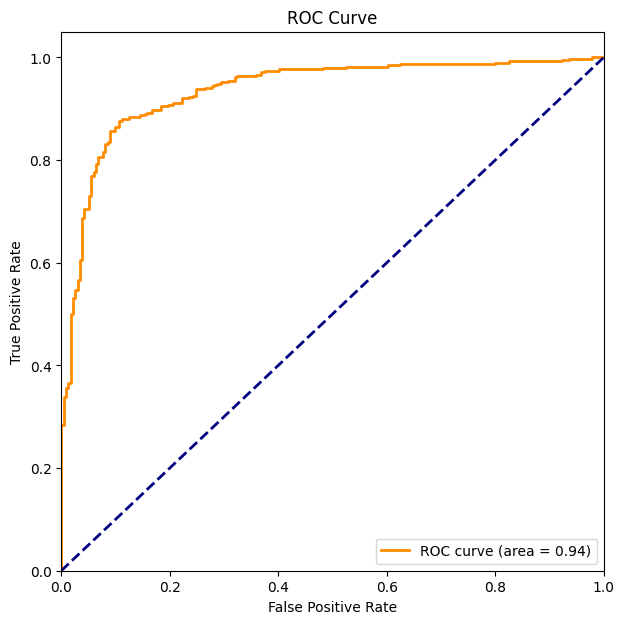

In [17]:
# PR Curve
precision, recall, _ = precision_recall_curve(labels, probs)
plt.figure(figsize=(7, 7))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


### Visualizing Training Time vs Batch Size for Different GPU Counts

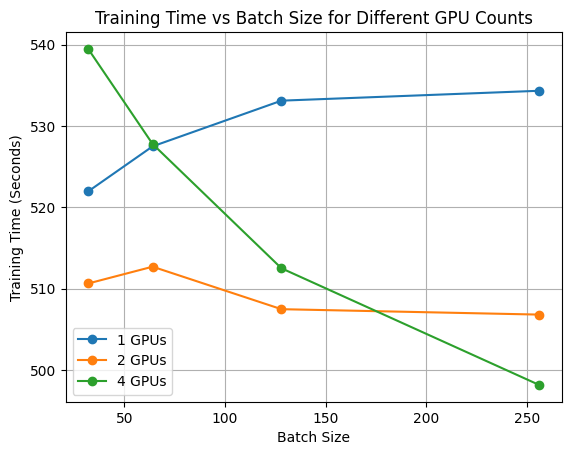

In [18]:
# Read the CSV file into a DataFrame
df = pd.read_csv('training_times.csv')

# Get unique GPU counts
gpu_counts = df['GPUs'].unique()

# Plot line graph for each GPU count
for gpu_count in gpu_counts:
    gpu_df = df[df['GPUs'] == gpu_count]
    plt.plot(gpu_df['Batch Size'], gpu_df['Training Time (Seconds)'], 'o-',
             label=f'{gpu_count} GPUs')

# Add labels and title
plt.xlabel('Batch Size')
plt.ylabel('Training Time (Seconds)')
plt.title('Training Time vs Batch Size for Different GPU Counts')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

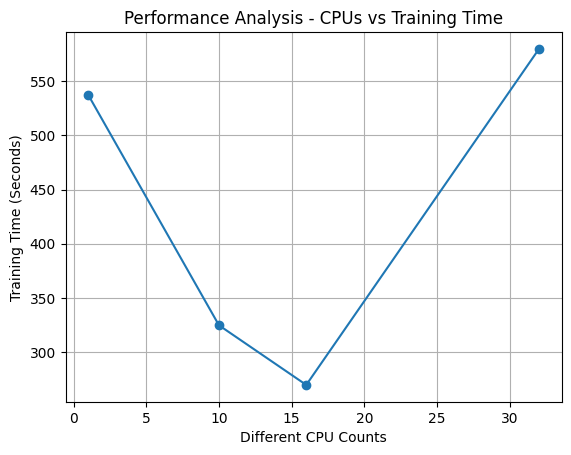

In [19]:
# Read the CSV file into a DataFrame
df = pd.read_csv('training_times-CPU.csv')

# Get unique CPU counts
cpu_counts = df['CPUs'].unique()

plt.plot(cpu_counts, df['Training Time (Seconds)'], 'o-')

# Add labels and title
plt.xlabel('Different CPU Counts')
plt.ylabel('Training Time (Seconds)')
plt.title('Performance Analysis - CPUs vs Training Time')
plt.grid(True)

# Show the plot
plt.show()

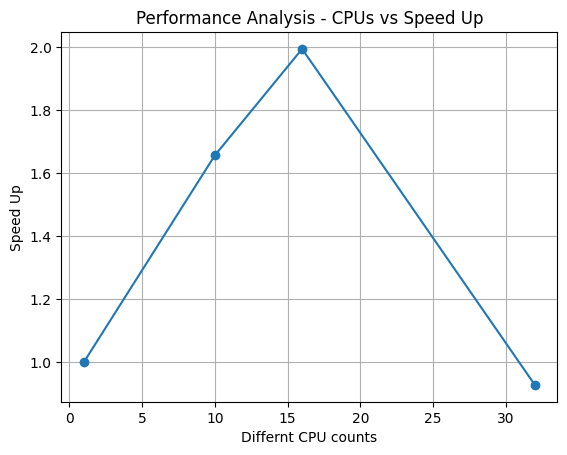

In [20]:
times = np.array(df['Training Time (Seconds)'])
speedup = [times[0] / t for t in times]
plt.plot(cpu_counts, speedup, 'o-')

# Add labels and title
plt.xlabel('Differnt CPU counts')
plt.ylabel('Speed Up')
plt.title('Performance Analysis - CPUs vs Speed Up')
plt.grid(True)

# Show the plot
plt.show()